## Step1.各種必要なライブラリのインポート

In [1]:
import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.applications import vgg19
from keras.layers import Dense, Input, GlobalAveragePooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

## Step2.学習用/テスト用データの準備から深層学習モデルの準備
次の順でセルを実行
1. データセット(cifar10)の読み込みと整形
2. imagenet学習済みモデルの読み込みと全結合層/出力層の形状の調整
3. モデルをcifar10で再学習

#### データセット(cifar10)の読み込みと整形

In [2]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

y_train_one_hot=np_utils.to_categorical(y_train,10)
y_test_one_hot=np_utils.to_categorical(y_test,10)

#### imagenet学習済みモデルの読み込みと全結合層/出力層の形状の調整

In [3]:
img_width = 32
img_height = 32
img_ch = 3
input_tensor = Input(shape=(img_width, img_height, img_ch))
vgg19_no_top = vgg19.VGG19(include_top=False,input_tensor=input_tensor,weights='imagenet')

x = vgg19_no_top.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
classification_output = Dense(10, activation="softmax")(x)

model = Model(inputs=vgg19_no_top.input,outputs=classification_output)
model.compile(loss="categorical_crossentropy",optimizer='sgd',metrics=["accuracy"])
model.summary()

Metal device set to: Apple M1


2024-06-01 23:07:57.232711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-01 23:07:57.232859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

#### モデルをcifar10で再学習

In [4]:
history=model.fit(x_train,y_train_one_hot,batch_size=16,epochs=10,verbose=1,validation_split=0.1)

Epoch 1/10


2024-06-01 23:08:18.125582: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-01 23:08:18.630198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2813/2813 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.6584

2024-06-01 23:11:03.334474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2813/2813 [==============================] - 172s 61ms/step - loss: 0.9919 - accuracy: 0.6584 - val_loss: 0.7189 - val_accuracy: 0.7632
Epoch 2/10
2813/2813 [==============================] - 183s 65ms/step - loss: 0.5869 - accuracy: 0.8004 - val_loss: 0.6977 - val_accuracy: 0.7562
Epoch 3/10
2813/2813 [==============================] - 171s 61ms/step - loss: 0.4401 - accuracy: 0.8487 - val_loss: 0.5139 - val_accuracy: 0.8232
Epoch 4/10
2813/2813 [==============================] - 169s 60ms/step - loss: 0.3433 - accuracy: 0.8824 - val_loss: 0.5730 - val_accuracy: 0.8142
Epoch 5/10
2813/2813 [==============================] - 166s 59ms/step - loss: 0.2722 - accuracy: 0.9057 - val_loss: 0.5024 - val_accuracy: 0.8394
Epoch 6/10
2813/2813 [==============================] - 170s 61ms/step - loss: 0.2112 - accuracy: 0.9282 - val_loss: 0.4744 - val_accuracy: 0.8526
Epoch 7/10
2813/2813 [==============================] - 170s 60ms/step - loss: 0.1639 - accuracy: 0.9422 - val_loss: 0.4866 - val

# Step3.テストデータに対する推論処理と結果表示
次の流れでセルを実行
1. テストデータに対して学習済みモデルで推論
2. 推論結果の内訳を混同行列で表示
3. 評価指標(適合率,再現率,F1値)を計算

#### テストデータに対して学習済みモデルで推論

In [5]:
# one-hotベクトル形式から元の教師ラベル値に戻す
def oneHotDecoder(oneHotVector):
    decodeResult = []
    for ohv in oneHotVector:
        decodeResult.append(np.argmax(ohv))
    return np.array(decodeResult)

predicted = oneHotDecoder(model.predict(x_test))

2024-06-01 23:37:15.194806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


#### 推論結果の内訳を混同行列で表示

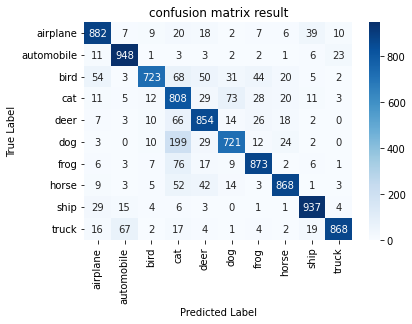

In [6]:
cmx = confusion_matrix(y_test,predicted)
object_labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
df = pd.DataFrame(cmx, index=object_labels, columns=object_labels)
sn.heatmap(df, annot=True, fmt='d',cmap='Blues')
plt.title("confusion matrix result")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#### 評価指標(適合率,再現率,F1値)を計算

In [7]:
print(classification_report(y_test,predicted,target_names=object_labels))

              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.90      0.95      0.92      1000
        bird       0.92      0.72      0.81      1000
         cat       0.61      0.81      0.70      1000
        deer       0.81      0.85      0.83      1000
         dog       0.83      0.72      0.77      1000
        frog       0.87      0.87      0.87      1000
       horse       0.90      0.87      0.88      1000
        ship       0.91      0.94      0.92      1000
       truck       0.95      0.87      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



#### モデルの保存

In [9]:
model.save("cifar10-learned-model.h5")